In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [ ]:
import numpy as np
import os
import cv2
from tensorflow.keras.utils import to_categorical

# Function to process images in a folder
def process_images_in_folder(input_folder):
    x = []  # Array to store stacked images
    y = []  # Array to store labels
    label_map = {}  # Dictionary to map folder names to numeric labels
    label_count = 0

    for folder_name in os.listdir(input_folder):
        folder_path = os.path.join(input_folder, folder_name)
        if os.path.isdir(folder_path):
            print(f"Processing images in folder: {folder_path}")
            if folder_name not in label_map:
                label_map[folder_name] = label_count
                label_count += 1
            label = label_map[folder_name]

            # Initialize a list to store images for stacking
            

            # Count the number of images in the folder
            num_images = 0
            
            
            sub_folder = []
            for subfolder_name in os.listdir(folder_path):
                subfolder_path = os.path.join(folder_path, subfolder_name)
                sub_folder.append(subfolder_path)
            for i in range(200):
                images = []
                for sdr in sub_folder:
                    try:
                        file_name = f'{sdr}/spectrogram{i}.png'
                        img = cv2.imread(file_name, cv2.IMREAD_COLOR)
                        resized_image = cv2.resize(img, (224, 224))
                        images.append(resized_image)
                    except:
                        file_name = f'{sdr}/spectogram{i}.png'
                        img = cv2.imread(file_name, cv2.IMREAD_COLOR)
                        resized_image = cv2.resize(img,(224,224))
                        
                        images.append(resized_image)

#                 stacked_image = np.stack(images, axis=-1)
                images = np.array(images)
                x.append(images)
                y.append(label_map[folder_name])
                
                 
    x = np.array(x)
    y = np.array(y)
    return x, y, label_map

# Define the path to the "Fault" folder
faults_folder = "/kaggle/input/fault-ml/Fault"

# Process images in the "Fault" folder
x, y, label_map = process_images_in_folder(faults_folder)

# Check the shape of the arrays
print("Shape of x:", x.shape)
print("Shape of y:", y.shape)

# Print the label mapping
print("Label Mapping:")
print(label_map)

In [3]:
x[0][0].shape

(224, 224, 3)

In [7]:
from tensorflow.keras.applications.xception import Xception, preprocess_input  # Import Xception model and preprocess_input function


In [8]:
xception_model = Xception(weights='imagenet', include_top=False, pooling='avg')


In [9]:

x[0].shape
a = xception_model.predict(x[0])
concatenated_features = np.concatenate((a[0], a[1], a[2]), axis=0)

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


In [ ]:
concatenated_features = []

# Iterate over the features in x
for features_set in x:
    # Predict features for each image in the set
    predictions = xception_model.predict(features_set)
    
    # Concatenate the predictions along the first axis
    concatenated_features_set = np.concatenate((predictions[0], predictions[1], predictions[2]), axis=0)
    
    # Append the concatenated features to the list
    concatenated_features.append(concatenated_features_set)

# Convert the list of concatenated features to a numpy array
concatenated_features = np.array(concatenated_features)

# Check the shape of the concatenated features array
print("Shape of concatenated features array:", concatenated_features.shape)


In [11]:
concatenated_features.shape

(2000, 6144)

In [12]:
y.shape

(2000,)

Shape of x_train_pca: (1400, 78)
Shape of x_val_pca: (300, 78)
Shape of x_test_pca: (300, 78)
Validation Accuracy after PCA: 0.92
Test Accuracy after PCA: 0.9333333333333333
F1 Score on Validation Data: 0.9206597685851894
F1 Score on Test Data: 0.9340609539766412


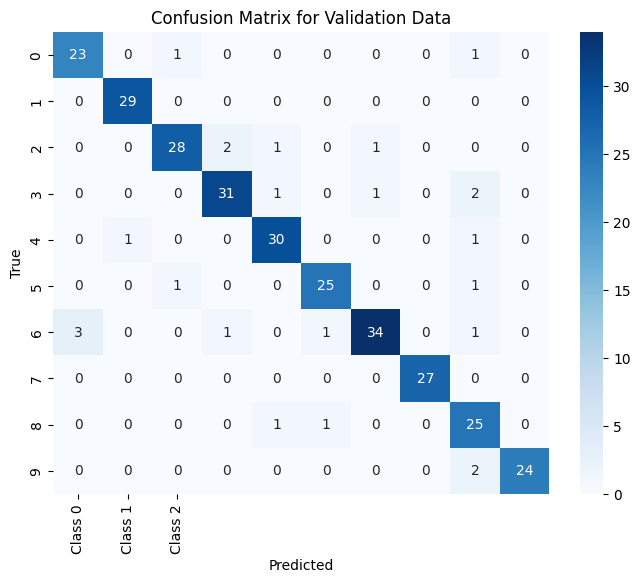

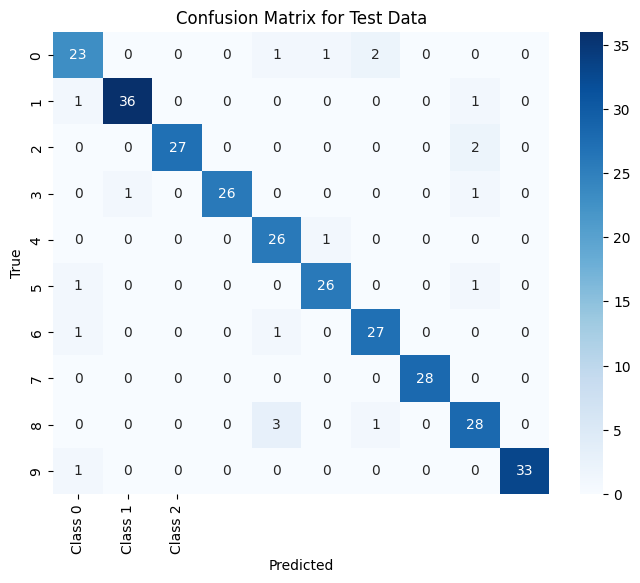

In [14]:
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming concatenated_features and y are already defined

# Split the concatenated features and labels into training, validation, and testing sets
x_train_val, x_test, y_train_val, y_test = train_test_split(concatenated_features, y, test_size=0.15, random_state=42)
x_train, x_val, y_train, y_val = train_test_split(x_train_val, y_train_val, test_size=0.176, random_state=42)

# Apply PCA with n_components=0.95 (retain 95% of variance)
pca = PCA(n_components=0.99)
x_train_pca = pca.fit_transform(x_train)
x_val_pca = pca.transform(x_val)
x_test_pca = pca.transform(x_test)

# Print the shapes of the PCA-transformed datasets
print("Shape of x_train_pca:", x_train_pca.shape)
print("Shape of x_val_pca:", x_val_pca.shape)
print("Shape of x_test_pca:", x_test_pca.shape)

# Initialize the Gaussian Naive Bayes classifier
gnb = GaussianNB()

# Train the classifier on the PCA-transformed training data
gnb.fit(x_train_pca, y_train)

# Predict labels for the PCA-transformed validation data
y_val_pred = gnb.predict(x_val_pca)

# Calculate the accuracy of the classifier on PCA-transformed validation data
accuracy_val = accuracy_score(y_val, y_val_pred)
print("Validation Accuracy after PCA:", accuracy_val)

# Predict labels for the PCA-transformed test data
y_test_pred = gnb.predict(x_test_pca)

# Calculate the accuracy of the classifier on PCA-transformed test data
accuracy_test = accuracy_score(y_test, y_test_pred)
print("Test Accuracy after PCA:", accuracy_test)

# Calculate F1 score for validation data
f1_val = f1_score(y_val, y_val_pred, average='weighted')
print("F1 Score on Validation Data:", f1_val)

# Calculate F1 score for test data
f1_test = f1_score(y_test, y_test_pred, average='weighted')
print("F1 Score on Test Data:", f1_test)

# Calculate confusion matrix for validation data
cm_val = confusion_matrix(y_val, y_val_pred)

# Calculate confusion matrix for test data
cm_test = confusion_matrix(y_test, y_test_pred)

# Plot confusion matrix for validation data
plt.figure(figsize=(8, 6))
sns.heatmap(cm_val, annot=True, fmt='d', cmap='Blues', xticklabels=["Class 0", "Class 1", "Class 2"])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix for Validation Data')
plt.savefig('confusion_matrix_validation.png')  # Save the confusion matrix
plt.show()

# Plot confusion matrix for test data
plt.figure(figsize=(8, 6))
sns.heatmap(cm_test, annot=True, fmt='d', cmap='Blues', xticklabels=["Class 0", "Class 1", "Class 2"])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix for Test Data')
plt.savefig('confusion_matrix_test.png')  # Save the confusion matrix
plt.show()





Validation Accuracy before Calibration: 0.8533333333333334
Test Accuracy after Calibration: 0.20666666666666667
F1 Score on Validation Data: 0.8523699152738948
F1 Score on Test Data: 0.13060901158462135


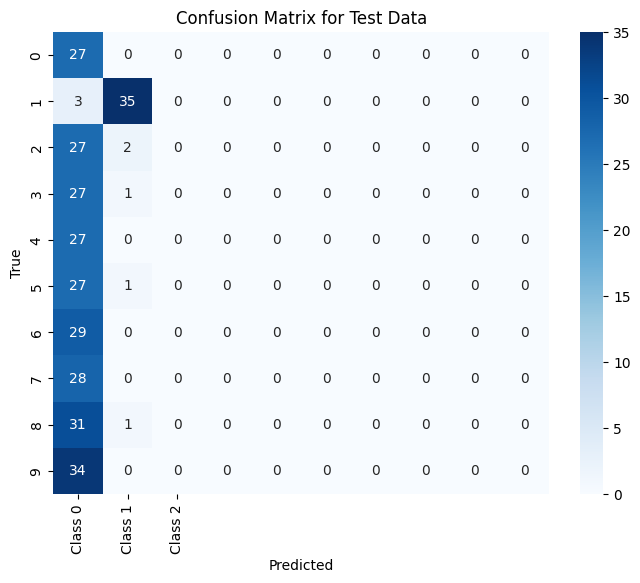

In [24]:
# from sklearn.model_selection import train_test_split, GridSearchCV
# from sklearn.decomposition import PCA
# from sklearn.naive_bayes import GaussianNB
# from sklearn.metrics import accuracy_score, confusion_matrix, f1_score
# from sklearn.calibration import CalibratedClassifierCV
# import seaborn as sns
# import matplotlib.pyplot as plt

# # Assuming concatenated_features and y are already defined

# # Split the concatenated features and labels into training, validation, and testing sets
# x_train_val, x_test, y_train_val, y_test = train_test_split(concatenated_features, y, test_size=0.15, random_state=42)
# x_train, x_val, y_train, y_val = train_test_split(x_train_val, y_train_val, test_size=0.176, random_state=42)

# # Apply PCA with n_components=0.95 (retain 95% of variance)
# pca = PCA(n_components=0.95)
# x_train_pca = pca.fit_transform(x_train)
# x_val_pca = pca.transform(x_val)
# x_test_pca = pca.transform(x_test)

# # Initialize the Gaussian Naive Bayes classifier
# gnb = GaussianNB()

# # Train the classifier on the training data
# gnb.fit(x_train_pca, y_train)

# # Predict labels for the validation data
# y_val_pred = gnb.predict(x_val_pca)

# # Calculate the accuracy of the classifier on the validation data
# accuracy_val = accuracy_score(y_val, y_val_pred)
# print("Validation Accuracy before Calibration:", accuracy_val)

# # Calibrate the classifier
# calibrated_classifier = CalibratedClassifierCV(gnb, method='isotonic', cv='prefit')
# calibrated_classifier.fit(x_val_pca, y_val)

# # Predict probabilities for the test data
# y_test_prob = calibrated_classifier.predict_proba(x_test_pca)

# # Convert probabilities to class predictions using a threshold
# threshold = 0.5
# y_test_pred_calibrated = (y_test_prob[:, 1] > threshold).astype(int)

# # Calculate accuracy after calibration for test data
# accuracy_test_calibrated = accuracy_score(y_test, y_test_pred_calibrated)
# print("Test Accuracy after Calibration:", accuracy_test_calibrated)

# # Calculate F1 score for validation and test data
# f1_val = f1_score(y_val, y_val_pred, average='weighted')
# f1_test = f1_score(y_test, y_test_pred_calibrated, average='weighted')

# print("F1 Score on Validation Data:", f1_val)
# print("F1 Score on Test Data:", f1_test)

# # Plot confusion matrix for test data
# cm_test = confusion_matrix(y_test, y_test_pred_calibrated)
# plt.figure(figsize=(8, 6))
# sns.heatmap(cm_test, annot=True, fmt='d', cmap='Blues', xticklabels=["Class 0", "Class 1", "Class 2"])
# plt.xlabel('Predicted')
# plt.ylabel('True')
# plt.title('Confusion Matrix for Test Data')
# plt.savefig('confusion_matrix_test.png')  # Save the confusion matrix
# plt.show()



In [16]:
from skopt import BayesSearchCV
from sklearn.naive_bayes import GaussianNB
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline

# Define the steps of the pipeline
pipeline = Pipeline([
    ('pca', PCA()),  # Optionally include PCA
    ('nb', GaussianNB())
])

# Define the parameter search space
param_space = {
    'pca__n_components': (0.95, 0.99),  # PCA components
}

# Define BayesSearchCV
bayes_search = BayesSearchCV(pipeline, param_space, cv=5, n_iter=20, scoring='accuracy', random_state=42)

# Perform Bayesian optimization
bayes_search.fit(x_train_val, y_train_val)

# Print the best parameters found
print("Best parameters:", bayes_search.best_params_)

# Get the best model
best_model = bayes_search.best_estimator_

# Evaluate the best model
accuracy_test = best_model.score(x_test, y_test)
print("Test Accuracy after Hyperparameter Tuning:", accuracy_test)
# Calculate confusion matrix for validation data
cm_val = confusion_matrix(y_val, y_val_pred)

# Calculate confusion matrix for test data
cm_test = confusion_matrix(y_test, y_test_pred)

# Plot confusion matrix for validation data
plt.figure(figsize=(8, 6))
sns.heatmap(cm_val, annot=True, fmt='d', cmap='Blues', xticklabels=["Class 0", "Class 1", "Class 2"])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix for Validation Data')
plt.savefig('confusion_matrix_validation.png')  # Save the confusion matrix
plt.show()

# Plot confusion matrix for test data
plt.figure(figsize=(8, 6))
sns.heatmap(cm_test, annot=True, fmt='d', cmap='Blues', xticklabels=["Class 0", "Class 1", "Class 2"])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix for Test Data')
plt.savefig('confusion_matrix_test.png')  # Save the confusion matrix
plt.show()



Best parameters: OrderedDict([('pca__n_components', 0.99)])
Test Accuracy after Hyperparameter Tuning: 0.9333333333333333


Shape of x_train_pca: (1400, 78)
Shape of x_val_pca: (300, 78)
Shape of x_test_pca: (300, 78)
Validation Accuracy after PCA: 0.9533333333333334
Test Accuracy after PCA: 0.96
Training Accuracy after PCA: 1.0
F1 Score on Validation Data: 0.9538120391411055
F1 Score on Test Data: 0.9600461205602572


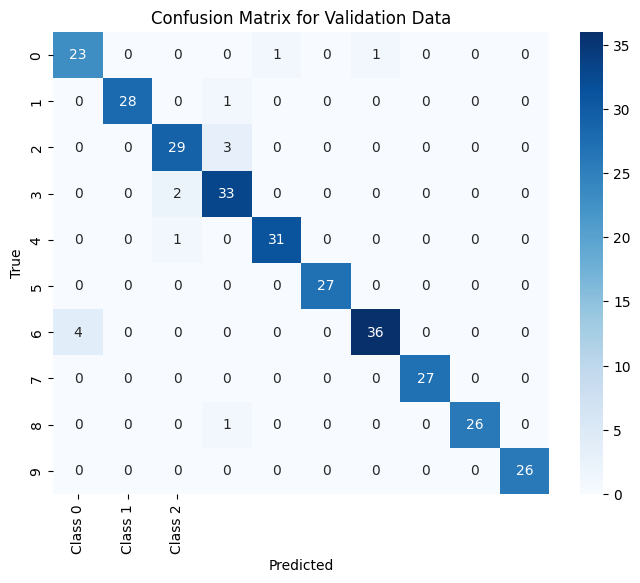

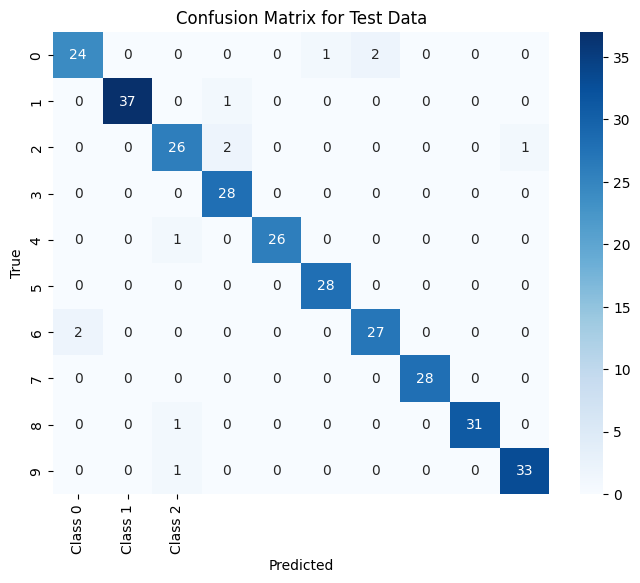

In [35]:
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score

# Assuming concatenated_features and y are already defined

# Split the concatenated features and labels into training, validation, and testing sets
x_train_val, x_test, y_train_val, y_test = train_test_split(concatenated_features, y, test_size=0.15, random_state=42)
x_train, x_val, y_train, y_val = train_test_split(x_train_val, y_train_val, test_size=0.176, random_state=42)

# Apply PCA with n_components=0.99 (retain 99% of variance)
pca = PCA(n_components=0.99)
x_train_pca = pca.fit_transform(x_train)
x_val_pca = pca.transform(x_val)
x_test_pca = pca.transform(x_test)

# Print the shapes of the PCA-transformed datasets
print("Shape of x_train_pca:", x_train_pca.shape)
print("Shape of x_val_pca:", x_val_pca.shape)
print("Shape of x_test_pca:", x_test_pca.shape)

# Initialize the Random Forest classifier
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)

# Train the classifier on the PCA-transformed training data
rf_classifier.fit(x_train_pca, y_train)

# Predict labels for the PCA-transformed validation data
y_val_pred = rf_classifier.predict(x_val_pca)

# Calculate the accuracy of the classifier on PCA-transformed validation data
accuracy_val = accuracy_score(y_val, y_val_pred)
print("Validation Accuracy after PCA:", accuracy_val)

# Predict labels for the PCA-transformed test data
y_test_pred = rf_classifier.predict(x_test_pca)

# Calculate the accuracy of the classifier on PCA-transformed test data
accuracy_test = accuracy_score(y_test, y_test_pred)
print("Test Accuracy after PCA:", accuracy_test)

# Predict labels for the PCA-transformed training data
y_train_pred = rf_classifier.predict(x_train_pca)

# Calculate the accuracy of the classifier on PCA-transformed training data
accuracy_train = accuracy_score(y_train, y_train_pred)
print("Training Accuracy after PCA:", accuracy_train)

# Calculate F1 score for validation data using the Random Forest model
f1_val = f1_score(y_val, y_val_pred, average='weighted')
print("F1 Score on Validation Data:", f1_val)

# Calculate F1 score for test data using the Random Forest model
f1_test = f1_score(y_test, y_test_pred, average='weighted')
print("F1 Score on Test Data:", f1_test)
cm_val = confusion_matrix(y_val, y_val_pred)

# Calculate confusion matrix for test data
cm_test = confusion_matrix(y_test, y_test_pred)

# Plot confusion matrix for validation data
plt.figure(figsize=(8, 6))
sns.heatmap(cm_val, annot=True, fmt='d', cmap='Blues', xticklabels=["Class 0", "Class 1", "Class 2"])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix for Validation Data')
plt.savefig('confusion_matrix_validation_rf.png')  # Save the confusion matrix
plt.show()

# Plot confusion matrix for test data
plt.figure(figsize=(8, 6))
sns.heatmap(cm_test, annot=True, fmt='d', cmap='Blues', xticklabels=["Class 0", "Class 1", "Class 2"])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix for Test Data')
plt.savefig('confusion_matrix_test_rf.png')  # Save the confusion matrix
plt.show()





In [ ]:
# from sklearn.model_selection import GridSearchCV
# from sklearn.ensemble import RandomForestClassifier
# from sklearn.metrics import accuracy_score, f1_score
# print(9)
# # Define the Random Forest classifier
# rf_classifier = RandomForestClassifier(random_state=42)

# # Define the hyperparameters grid for tuning
# param_grid = {
#     'n_estimators': [100, 200, 300],  # Number of trees in the forest
#     'max_depth': [None, 10, 20],  # Maximum depth of the tree
#     'min_samples_split': [2, 5, 10],  # Minimum samples required to split a node
#     'min_samples_leaf': [1, 2, 4]  # Minimum samples required at each leaf node
# }

# # Initialize GridSearchCV with the classifier and hyperparameters grid
# grid_search = GridSearchCV(estimator=rf_classifier, param_grid=param_grid, cv=5)

# # Fit GridSearchCV to the training data
# grid_search.fit(x_train_pca, y_train)

# # Get the best parameters and the best score from GridSearchCV
# best_params = grid_search.best_params_
# best_score = grid_search.best_score_

# # Print the best parameters and the best score
# print("Best Parameters:", best_params)
# print("Best Score:", best_score)

# # Use the best model from GridSearchCV for predictions
# best_rf_classifier = grid_search.best_estimator_

# # Predict labels for the PCA-transformed validation data using the best model
# y_val_pred = best_rf_classifier.predict(x_val_pca)

# # Calculate the accuracy of the best model on PCA-transformed validation data
# accuracy_val = accuracy_score(y_val, y_val_pred)
# print("Validation Accuracy after Hyperparameter Tuning:", accuracy_val)

# # Predict labels for the PCA-transformed test data using the best model
# y_test_pred = best_rf_classifier.predict(x_test_pca)

# # Calculate the accuracy of the best model on PCA-transformed test data
# accuracy_test = accuracy_score(y_test, y_test_pred)
# print("Test Accuracy after Hyperparameter Tuning:", accuracy_test)

# # Calculate F1 score for validation data using the best model
# f1_val = f1_score(y_val, y_val_pred, average='weighted')
# print("F1 Score on Validation Data after Hyperparameter Tuning:", f1_val)

# # Calculate F1 score for test data using the best model
# f1_test = f1_score(y_test, y_test_pred, average='weighted')
# print("F1 Score on Test Data after Hyperparameter Tuning:", f1_test)
# cm_val = confusion_matrix(y_val, y_val_pred)

# # Calculate confusion matrix for test data
# cm_test = confusion_matrix(y_test, y_test_pred)

# # Plot confusion matrix for validation data
# plt.figure(figsize=(8, 6))
# sns.heatmap(cm_val, annot=True, fmt='d', cmap='Blues', xticklabels=["Class 0", "Class 1", "Class 2"])
# plt.xlabel('Predicted')
# plt.ylabel('True')
# plt.title('Confusion Matrix for Validation Data')
# plt.savefig('confusion_matrix_validation.png')  # Save the confusion matrix
# plt.show()

# # Plot confusion matrix for test data
# plt.figure(figsize=(8, 6))
# sns.heatmap(cm_test, annot=True, fmt='d', cmap='Blues', xticklabels=["Class 0", "Class 1", "Class 2"])
# plt.xlabel('Predicted')
# plt.ylabel('True')
# plt.title('Confusion Matrix for Test Data')
# plt.savefig('confusion_matrix_test.png')  # Save the confusion matrix
# plt.show()




In [ ]:
# from sklearn.model_selection import GridSearchCV
# from sklearn.ensemble import RandomForestClassifier
# from sklearn.metrics import accuracy_score, f1_score
# print(9)
# # Define the Random Forest classifier
# rf_classifier = RandomForestClassifier(random_state=42)

# # Define the hyperparameters grid for tuning
# param_grid = {
#     'n_estimators': [100, 200, 300],  # Number of trees in the forest
#     'max_depth': [None, 10, 20],  # Maximum depth of the tree
#     'min_samples_split': [2, 5, 10],  # Minimum samples required to split a node
#     'min_samples_leaf': [1, 2, 4]  # Minimum samples required at each leaf node
# }

# # Initialize GridSearchCV with the classifier and hyperparameters grid
# grid_search = GridSearchCV(estimator=rf_classifier, param_grid=param_grid, cv=5)

# # Fit GridSearchCV to the training data
# grid_search.fit(x_train_pca, y_train)

# # Get the best parameters and the best score from GridSearchCV
# best_params = grid_search.best_params_
# best_score = grid_search.best_score_

# # Print the best parameters and the best score
# print("Best Parameters:", best_params)
# print("Best Score:", best_score)

# # Use the best model from GridSearchCV for predictions
# best_rf_classifier = grid_search.best_estimator_

# # Predict labels for the PCA-transformed validation data using the best model
# y_val_pred = best_rf_classifier.predict(x_val_pca)

# # Calculate the accuracy of the best model on PCA-transformed validation data
# accuracy_val = accuracy_score(y_val, y_val_pred)
# print("Validation Accuracy after Hyperparameter Tuning:", accuracy_val)

# # Predict labels for the PCA-transformed test data using the best model
# y_test_pred = best_rf_classifier.predict(x_test_pca)

# # Calculate the accuracy of the best model on PCA-transformed test data
# accuracy_test = accuracy_score(y_test, y_test_pred)
# print("Test Accuracy after Hyperparameter Tuning:", accuracy_test)

# # Calculate F1 score for validation data using the best model
# f1_val = f1_score(y_val, y_val_pred, average='weighted')
# print("F1 Score on Validation Data after Hyperparameter Tuning:", f1_val)

# # Calculate F1 score for test data using the best model
# f1_test = f1_score(y_test, y_test_pred, average='weighted')
# print("F1 Score on Test Data after Hyperparameter Tuning:", f1_test)


Best Parameters: OrderedDict([('max_depth', 14), ('min_samples_leaf', 1), ('min_samples_split', 2), ('n_estimators', 487)])
Best Score: 0.9357142857142857
Validation Accuracy after Bayesian Optimization: 0.9433333333333334
Test Accuracy after Bayesian Optimization: 0.93
F1 Score on Validation Data after Bayesian Optimization: 0.9440044436433628
F1 Score on Test Data after Bayesian Optimization: 0.9298849465078888


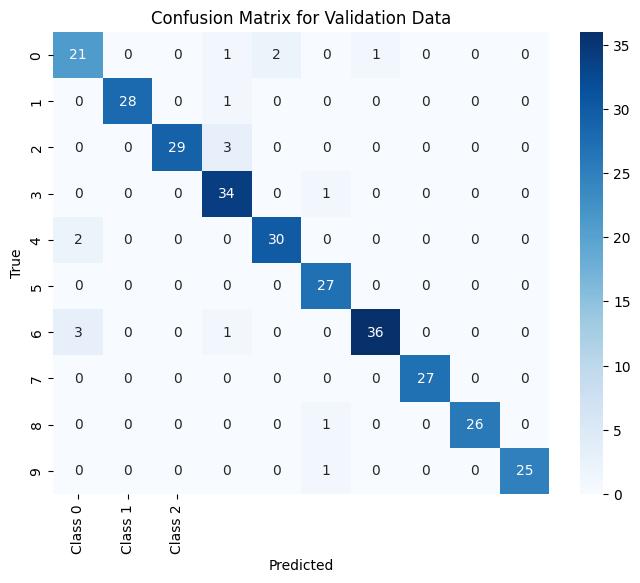

AttributeError: 'int' object has no attribute 'split'

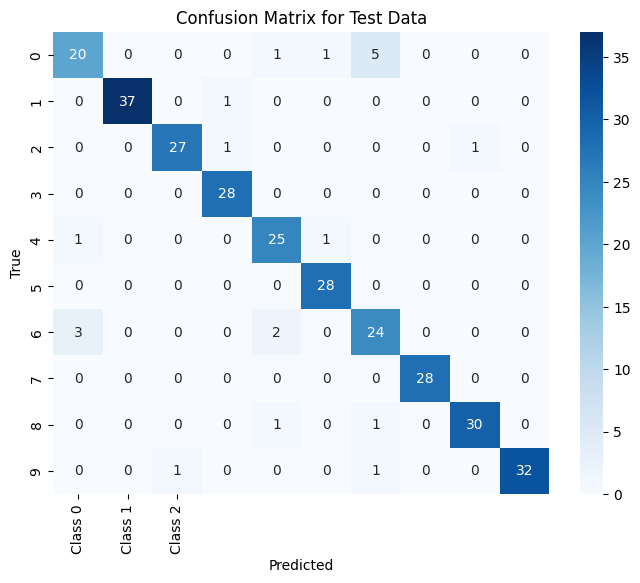

In [27]:
from skopt import BayesSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score

# Define the Random Forest classifier
rf_classifier = RandomForestClassifier(random_state=42)

# Define the hyperparameters search space for tuning
param_space = {
    'n_estimators': (100, 500),  # Number of trees in the forest
    'max_depth': (1, 20),  # Maximum depth of the tree
    'min_samples_split': (2, 10),  # Minimum samples required to split a node
    'min_samples_leaf': (1, 5)  # Minimum samples required at each leaf node
}

# Initialize BayesSearchCV with the classifier and hyperparameters search space
bayes_search = BayesSearchCV(estimator=rf_classifier, search_spaces=param_space, cv=5, n_iter=50, random_state=42)

# Fit BayesSearchCV to the training data
bayes_search.fit(x_train_pca, y_train)

# Get the best parameters and the best score from BayesSearchCV
best_params = bayes_search.best_params_
best_score = bayes_search.best_score_

# Print the best parameters and the best score
print("Best Parameters:", best_params)
print("Best Score:", best_score)

# Use the best model from BayesSearchCV for predictions
best_rf_classifier = bayes_search.best_estimator_

# Predict labels for the PCA-transformed validation data using the best model
y_val_pred = best_rf_classifier.predict(x_val_pca)

# Calculate the accuracy of the best model on PCA-transformed validation data
accuracy_val = accuracy_score(y_val, y_val_pred)
print("Validation Accuracy after Bayesian Optimization:", accuracy_val)

# Predict labels for the PCA-transformed test data using the best model
y_test_pred = best_rf_classifier.predict(x_test_pca)

# Calculate the accuracy of the best model on PCA-transformed test data
accuracy_test = accuracy_score(y_test, y_test_pred)
print("Test Accuracy after Bayesian Optimization:", accuracy_test)

# Calculate F1 score for validation data using the best model
f1_val = f1_score(y_val, y_val_pred, average='weighted')
print("F1 Score on Validation Data after Bayesian Optimization:", f1_val)

# Calculate F1 score for test data using the best model
f1_test = f1_score(y_test, y_test_pred, average='weighted')
print("F1 Score on Test Data after Bayesian Optimization:", f1_test)
# Calculate confusion matrix for validation data
cm_val = confusion_matrix(y_val, y_val_pred)

# Calculate confusion matrix for test data
cm_test = confusion_matrix(y_test, y_test_pred)

# Plot confusion matrix for validation data
plt.figure(figsize=(8, 6))
sns.heatmap(cm_val, annot=True, fmt='d', cmap='Blues', xticklabels=["Class 0", "Class 1", "Class 2"])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix for Validation Data')
plt.savefig('confusion_matrix_validation_bayes_rf.png')  # Save the confusion matrix
plt.show()

# Plot confusion matrix for test data
plt.figure(figsize=(8, 6))
sns.heatmap(cm_test, annot=True, fmt='d', cmap='Blues', xticklabels=["Class 0", "Class 1", "Class 2"])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix for Test Data')
plt.savefig('confusion_matrix_test_bayes_rf.png')  # Save the confusion matrix
plt.show()



In [ ]:
# from sklearn.model_selection import train_test_split
# from sklearn.decomposition import PCA
# from sklearn.ensemble import GradientBoostingClassifier
# from sklearn.calibration import CalibratedClassifierCV
# from skopt import BayesSearchCV
# from sklearn.metrics import accuracy_score, confusion_matrix
# import seaborn as sns
# import matplotlib.pyplot as plt

# # Assuming concatenated_features and y are already defined

# # Split the concatenated features and labels into training, validation, and testing sets
# x_train_val, x_test, y_train_val, y_test = train_test_split(concatenated_features, y, test_size=0.15, random_state=42)
# x_train, x_val, y_train, y_val = train_test_split(x_train_val, y_train_val, test_size=0.176, random_state=42)

# Apply PCA with n_components=0.95 (retain 95% of variance)
# pca = PCA(n_components=0.95)
# x_train_pca = pca.fit_transform(x_train)
# x_val_pca = pca.transform(x_val)
# x_test_pca = pca.transform(x_test)

# Define the Gradient Boosting classifier
# gb_classifier = GradientBoostingClassifier(random_state=42)

# # Define the hyperparameters search space for tuning
# param_space_gb = {
#     'n_estimators': (100, 1000),
#     'learning_rate': (0.01, 1.0, 'log-uniform'),
#     'max_depth': (3, 10),
#     'min_samples_split': (2, 10),
#     'min_samples_leaf': (1, 5)
# }

# # Initialize BayesSearchCV with the classifier and hyperparameters search space
# bayes_search_gb = BayesSearchCV(estimator=gb_classifier, search_spaces=param_space_gb, cv=5, n_iter=50, random_state=42)

# # Initialize lists to store calibrated classifiers and their corresponding validation accuracies
# calibrated_classifiers = []
# validation_accuracies = []

# # Fit BayesSearchCV to the training data
# for train_index, val_index in bayes_search_gb.cv.split(x_train_pca, y_train):
#     # Split data into training and validation sets for this fold
#     x_train_fold, x_val_fold = x_train_pca[train_index], x_train_pca[val_index]
#     y_train_fold, y_val_fold = y_train[train_index], y_train[val_index]
    
#     # Fit the classifier to the training fold
#     bayes_search_gb.fit(x_train_fold, y_train_fold)
    
#     # Get the best model from BayesSearchCV
#     best_gb_classifier = bayes_search_gb.best_estimator_
    
#     # Calibrate the best model using CalibratedClassifierCV
#     calibrated_classifier = CalibratedClassifierCV(best_gb_classifier, method='sigmoid', cv='prefit')
#     calibrated_classifier.fit(x_val_fold, y_val_fold)
    
#     # Store the calibrated classifier and its corresponding validation accuracy
#     calibrated_classifiers.append(calibrated_classifier)
#     validation_accuracies.append(bayes_search_gb.best_score_)

# # Select the calibrated classifier with the highest validation accuracy
# best_calibrated_classifier = calibrated_classifiers[validation_accuracies.index(max(validation_accuracies))]

# # Predict labels for the validation data using the best calibrated classifier
# y_val_pred = best_calibrated_classifier.predict(x_val_pca)

# # Calculate confusion matrix for validation data
# cm_val = confusion_matrix(y_val, y_val_pred)

# # Plot confusion matrix for validation data
# plt.figure(figsize=(8, 6))
# sns.heatmap(cm_val, annot=True, fmt='d', cmap='Blues', xticklabels=["Class 0", "Class 1", "Class 2"])
# plt.xlabel('Predicted')
# plt.ylabel('True')
# plt.title('Confusion Matrix for Validation Data')
# plt.show()

# # Predict labels for the test data using the best calibrated classifier
# y_test_pred = best_calibrated_classifier.predict(x_test_pca)

# # Calculate confusion matrix for test data
# cm_test = confusion_matrix(y_test, y_test_pred)

# # Plot confusion matrix for test data
# plt.figure(figsize=(8, 6))
# sns.heatmap(cm_test, annot=True, fmt='d', cmap='Blues', xticklabels=["Class 0", "Class 1", "Class 2"])
# plt.xlabel('Predicted')
# plt.ylabel('True')
# plt.title('Confusion Matrix for Test Data')
# plt.show()



In [ ]:
# from sklearn.model_selection import train_test_split, GridSearchCV
# from sklearn.tree import DecisionTreeClassifier
# from sklearn.metrics import accuracy_score

# # Split the concatenated features and labels into training, validation, and testing sets
# x_train_val, x_test, y_train_val, y_test = train_test_split(concatenated_features, y, test_size=0.15, random_state=42)
# x_train, x_val, y_train, y_val = train_test_split(x_train_val, y_train_val, test_size=0.176, random_state=42)

# # Initialize Decision Tree Classifier
# dt_clf = DecisionTreeClassifier(random_state=42)

# # Define hyperparameters grid for tuning
# param_grid = {
#     'criterion': ['gini', 'entropy'],
#     'max_depth': [None, 5, 10, 20],
#     'min_samples_split': [2, 5, 10],
#     'min_samples_leaf': [1, 2, 4],
#     'max_features': ['auto', 'sqrt']
# }

# # Perform grid search using cross-validation (e.g., 5-fold cross-validation)
# grid_search = GridSearchCV(dt_clf, param_grid, cv=5, scoring='accuracy')

# # Train the grid search model on training data
# grid_search.fit(x_train, y_train)

# # Get the best estimator and its parameters
# best_dt_clf = grid_search.best_estimator_
# best_params = grid_search.best_params_

# print("Best Parameters:", best_params)

# # Predict labels for validation data using the best estimator
# y_val_pred = best_dt_clf.predict(x_val)

# # Calculate accuracy on validation data
# accuracy_val = accuracy_score(y_val, y_val_pred)
# print("Validation Accuracy with Best Decision Tree:", accuracy_val)

# # Predict labels for test data using the best estimator
# y_test_pred = best_dt_clf.predict(x_test)

# # Calculate accuracy on test data
# accuracy_test = accuracy_score(y_test, y_test_pred)
# print("Test Accuracy with Best Decision Tree:", accuracy_test)


In [ ]:
# from sklearn.model_selection import train_test_split, GridSearchCV
# from sklearn.tree import DecisionTreeClassifier
# from sklearn.metrics import accuracy_score

# # Split the concatenated features and labels into training, validation, and testing sets
# x_train_val, x_test, y_train_val, y_test = train_test_split(concatenated_features, y, test_size=0.15, random_state=42)
# x_train, x_val, y_train, y_val = train_test_split(x_train_val, y_train_val, test_size=0.176, random_state=42)

# # Define the Decision Tree Classifier
# dt_clf = DecisionTreeClassifier(random_state=42)

# # Define the hyperparameter grid for tuning
# param_grid = {
#     'criterion': ['gini', 'entropy'],
#     'max_depth': [None, 5, 10, 20],
#     'min_samples_split': [2, 5, 10],
#     'min_samples_leaf': [1, 2, 4],
#     'max_features': ['auto', 'sqrt']
# }

# # Perform grid search using cross-validation (e.g., 5-fold cross-validation)
# grid_search = GridSearchCV(dt_clf, param_grid, cv=5, scoring='accuracy')

# # Train the grid search model on the training data
# grid_search.fit(x_train, y_train)

# # Get the best estimator and its parameters
# best_dt_clf = grid_search.best_estimator_
# best_params = grid_search.best_params_

# print("Best Parameters:", best_params)

# # Predict labels for the validation data using the best estimator
# y_val_pred = best_dt_clf.predict(x_val)

# # Calculate accuracy on the validation data
# accuracy_val = accuracy_score(y_val, y_val_pred)
# print("Validation Accuracy with Best Decision Tree:", accuracy_val)

# # Predict labels for the test data using the best estimator
# y_test_pred = best_dt_clf.predict(x_test)

# # Calculate accuracy on the test data
# accuracy_test = accuracy_score(y_test, y_test_pred)
# print("Test Accuracy with Best Decision Tree:", accuracy_test)


In [ ]:
# from sklearn.model_selection import train_test_split
# from sklearn.decomposition import PCA
# from sklearn.ensemble import AdaBoostClassifier
# from sklearn.metrics import accuracy_score

# # Assuming concatenated_features and y are already defined

# # Split the concatenated features and labels into training, validation, and testing sets
# x_train_val, x_test, y_train_val, y_test = train_test_split(concatenated_features, y, test_size=0.15, random_state=42)
# x_train, x_val, y_train, y_val = train_test_split(x_train_val, y_train_val, test_size=0.176, random_state=42)

# # Apply PCA with n_components=0.99 (retain 99% of variance)
# pca = PCA(n_components=0.95)
# x_train_pca = pca.fit_transform(x_train)
# x_val_pca = pca.transform(x_val)
# x_test_pca = pca.transform(x_test)

# # Print the shapes of the PCA-transformed datasets
# print("Shape of x_train_pca:", x_train_pca.shape)
# print("Shape of x_val_pca:", x_val_pca.shape)
# print("Shape of x_test_pca:", x_test_pca.shape)

# # Initialize the AdaBoost classifier with a base estimator (e.g., DecisionTreeClassifier)
# # You can adjust parameters such as n_estimators and learning_rate as needed
# adaboost_clf = AdaBoostClassifier(n_estimators=5000, learning_rate=1.0)

# # Train the classifier on the PCA-transformed training data
# adaboost_clf.fit(x_train_pca, y_train)

# # Predict labels for the PCA-transformed validation data
# y_val_pred = adaboost_clf.predict(x_val_pca)

# # Calculate the accuracy of the classifier on PCA-transformed validation data
# accuracy_val = accuracy_score(y_val, y_val_pred)
# print("Validation Accuracy with AdaBoost:", accuracy_val)

# # Predict labels for the PCA-transformed test data
# y_test_pred = adaboost_clf.predict(x_test_pca)

# # Calculate the accuracy of the classifier on PCA-transformed test data
# accuracy_test = accuracy_score(y_test, y_test_pred)
# print("Test Accuracy with AdaBoost:", accuracy_test)


In [ ]:
# from sklearn.model_selection import train_test_split, GridSearchCV
# from sklearn.ensemble import GradientBoostingClassifier
# from sklearn.metrics import accuracy_score

# # Split the concatenated features and labels into training, validation, and testing sets
# x_train_val, x_test, y_train_val, y_test = train_test_split(concatenated_features, y, test_size=0.15, random_state=42)
# x_train, x_val, y_train, y_val = train_test_split(x_train_val, y_train_val, test_size=0.176, random_state=42)

# # Initialize Gradient Boosting Machine (GBM) classifier
# gbm_clf = GradientBoostingClassifier(n_estimators=100, random_state=42)

# # Define hyperparameters grid for tuning
# param_grid = {
#     'learning_rate': [0.1, 0.05, 0.01],
#     'max_depth': [3, 5, 7],
#     'min_samples_split': [2, 5, 10],
#     'min_samples_leaf': [1, 2, 4]
# }

# # Perform grid search using cross-validation (e.g., 5-fold cross-validation)
# grid_search = GridSearchCV(gbm_clf, param_grid, cv=5, scoring='accuracy')

# # Train the grid search model on training data
# grid_search.fit(x_train, y_train)

# # Get the best estimator and its parameters
# best_gbm_clf = grid_search.best_estimator_
# best_params = grid_search.best_params_

# print("Best Parameters:", best_params)

# # Predict labels for validation data using the best estimator
# y_val_pred = best_gbm_clf.predict(x_val)

# # Calculate accuracy on validation data
# accuracy_val = accuracy_score(y_val, y_val_pred)
# print("Validation Accuracy with Best GBM:", accuracy_val)

# # Predict labels for test data using the best estimator
# y_test_pred = best_gbm_clf.predict(x_test)

# # Calculate accuracy on test data
# accuracy_test = accuracy_score(y_test, y_test_pred)
# print("Test Accuracy with Best GBM:", accuracy_test)


In [ ]:
from sklearn.model_selection import train_test_split

# Split the concatenated features and labels into training, testing, and validation sets
x_train, x_test_val, y_train, y_test_val = train_test_split(concatenated_features, y, test_size=0.3, random_state=42)
x_test, x_val, y_test, y_val = train_test_split(x_test_val, y_test_val, test_size=0.5, random_state=42)

# Print the shapes of the training, testing, and validation sets
print("Shape of x_train:", x_train.shape)
print("Shape of x_test:", x_test.shape)
print("Shape of x_val:", x_val.shape)
print("Shape of y_train:", y_train.shape)
print("Shape of y_test:", y_test.shape)
print("Shape of y_val:", y_val.shape)


In [ ]:
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score

# Initialize the Gaussian Naive Bayes classifier
gnb = GaussianNB()

# Train the classifier on the training data
gnb.fit(x_train, y_train)

# Predict labels for the test data
y_pred = gnb.predict(x_test)

# Calculate the accuracy of the classifier
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)


Accuracy: 0.99
F1 Score on Validation Data after Hyperparameter Tuning: 0.9440044436433628
F1 Score on Test Data after Hyperparameter Tuning: 0.9966677299308878
Classification Report:
              precision    recall  f1-score   support

           0       0.93      1.00      0.96        27
           1       1.00      1.00      1.00        38
           2       1.00      1.00      1.00        29
           3       1.00      0.96      0.98        28
           4       1.00      1.00      1.00        27
           5       0.97      1.00      0.98        28
           6       1.00      0.97      0.98        29
           7       1.00      1.00      1.00        28
           8       1.00      1.00      1.00        32
           9       1.00      0.97      0.99        34

    accuracy                           0.99       300
   macro avg       0.99      0.99      0.99       300
weighted avg       0.99      0.99      0.99       300



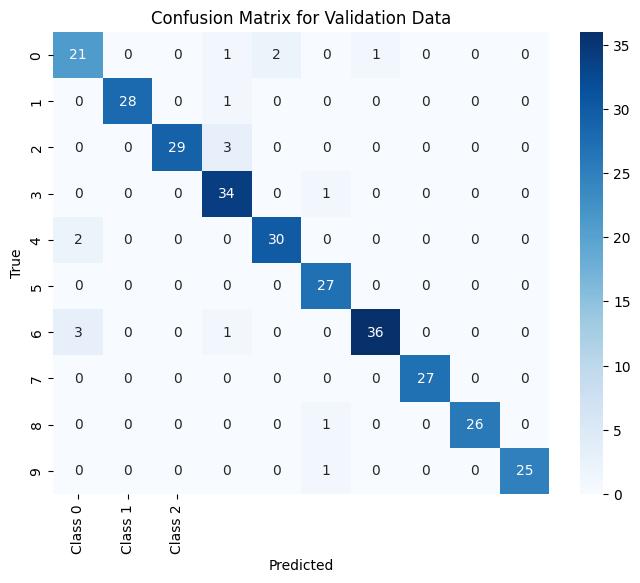

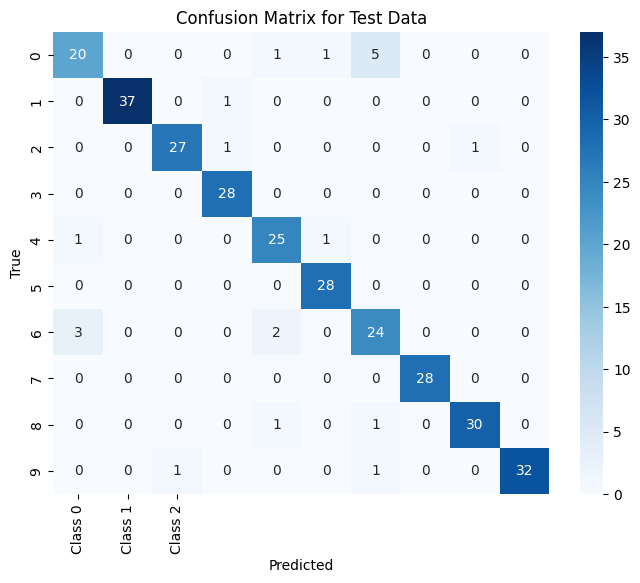

In [34]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

# Initialize the SVM classifier
svm_classifier = SVC(kernel='linear', random_state=42)

# Train the classifier on the training data
svm_classifier.fit(x_train, y_train)

# Predict labels for the test data
y_pred = svm_classifier.predict(x_test)

# Calculate the accuracy of the classifier
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)
from sklearn.metrics import classification_report

# Generate classification report
report = classification_report(y_test, y_pred)
f1_val = f1_score(y_val, y_val_pred, average='weighted')
print("F1 Score on Validation Data after Hyperparameter Tuning:", f1_val)

# Calculate F1 score for test data using the best model
f1_test = f1_score(y_test, y_test_pred, average='weighted')
print("F1 Score on Test Data after Hyperparameter Tuning:", f1_test)


# Print classification report
print("Classification Report:")
print(report)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_val, annot=True, fmt='d', cmap='Blues', xticklabels=["Class 0", "Class 1", "Class 2"])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix for Validation Data')
plt.savefig('confusion_matrix_validation_svm.png')  # Save the confusion matrix
plt.show()

# Plot confusion matrix for test data
plt.figure(figsize=(8, 6))
sns.heatmap(cm_test, annot=True, fmt='d', cmap='Blues', xticklabels=["Class 0", "Class 1", "Class 2"])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix for Test Data')
plt.savefig('confusion_matrix_test_svm.png')  # Save the confusion matrix
plt.show()


In [ ]:
pip install pgmpy


Best parameters found:
OrderedDict([('C', 83.7550967197731), ('gamma', 0.8844821246070537), ('kernel', 'linear')])
F1 Score on Validation Data after Bayesian Optimization: 0.9440044436433628
F1 Score on Test Data after Bayesian Optimization: 0.9966677299308878
Accuracy on test data after calibration: 0.9966666666666667


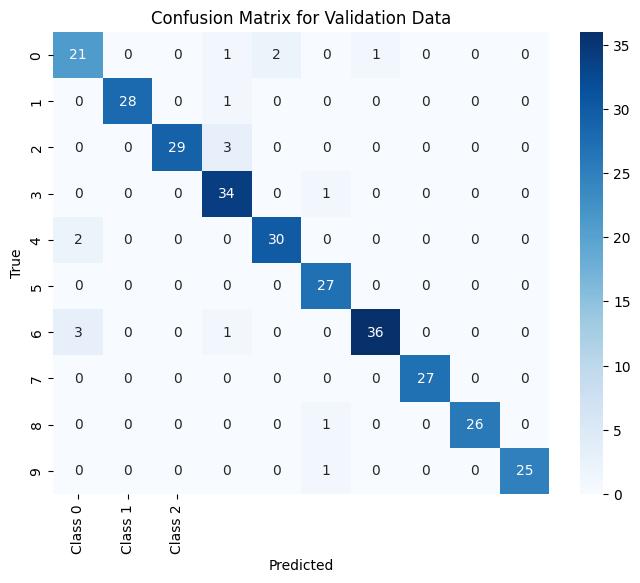

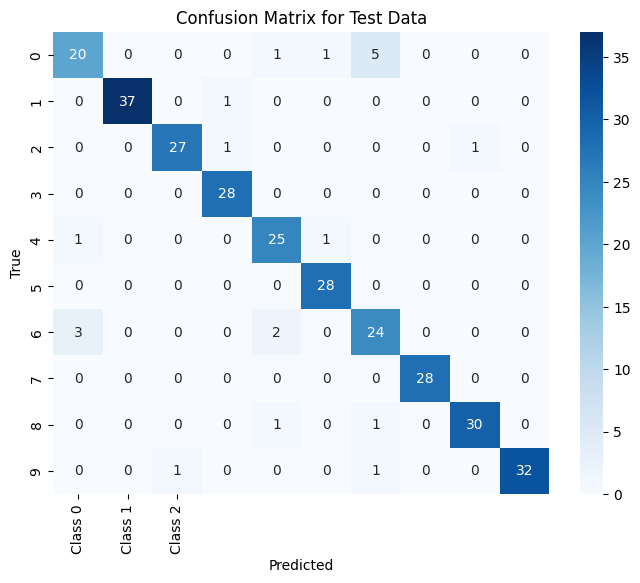

In [32]:
from sklearn.svm import SVC
from skopt import BayesSearchCV
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import accuracy_score

# Define the parameter search space for Bayesian optimization
param_space = {
    'C': (0.1, 100.0),           # Penalty parameter C
    'gamma': (0.01, 1.0),        # Kernel coefficient for 'rbf'
    'kernel': ['linear', 'rbf']  # Kernel type
}

# Initialize SVM classifier
svm = SVC()

# Initialize BayesSearchCV
bayes_search = BayesSearchCV(estimator=svm, search_spaces=param_space, cv=5, scoring='accuracy', n_iter=50, random_state=42, n_jobs=-1)

# Perform Bayesian optimization to find the best parameters
bayes_search.fit(x_train, y_train)

# Print the best parameters found
print("Best parameters found:")
print(bayes_search.best_params_)

# Get the best model from BayesSearchCV
best_svm = bayes_search.best_estimator_

# Calibrate the best model using CalibratedClassifierCV
calibrated_classifier = CalibratedClassifierCV(best_svm, method='sigmoid', cv=5)
calibrated_classifier.fit(x_train, y_train)

# Predict labels for the test data using the calibrated classifier
y_test_pred = calibrated_classifier.predict(x_test)
f1_val = f1_score(y_val, y_val_pred, average='weighted')
print("F1 Score on Validation Data after Bayesian Optimization:", f1_val)

# Calculate F1 score for test data using the best model
f1_test = f1_score(y_test, y_test_pred, average='weighted')
print("F1 Score on Test Data after Bayesian Optimization:", f1_test)
# Calculate accuracy on test data
accuracy = accuracy_score(y_test, y_test_pred)
print("Accuracy on test data after calibration:", accuracy)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_val, annot=True, fmt='d', cmap='Blues', xticklabels=["Class 0", "Class 1", "Class 2"])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix for Validation Data')
plt.savefig('confusion_matrix_validation_bayes_svm.png')  # Save the confusion matrix
plt.show()

# Plot confusion matrix for test data
plt.figure(figsize=(8, 6))
sns.heatmap(cm_test, annot=True, fmt='d', cmap='Blues', xticklabels=["Class 0", "Class 1", "Class 2"])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix for Test Data')
plt.savefig('confusion_matrix_test_bayes_svm.png')  # Save the confusion matrix
plt.show()





In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix

# Define the parameter grid
param_grid_rf = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Create a Random Forest Classifier
rf_classifier = RandomForestClassifier()

# Initialize GridSearchCV
grid_search_rf = GridSearchCV(rf_classifier, param_grid_rf, cv=5, scoring='accuracy')

# Fit the GridSearchCV instance
grid_search_rf.fit(x_train, y_train)

# Print the best parameters
print("Best Parameters for Random Forest:", grid_search_rf.best_params_)

# Get the best Random Forest model
best_rf_model = grid_search_rf.best_estimator_

# Evaluate the best model on the test set
y_pred_rf = best_rf_model.predict(x_test)

# Calculate accuracy
accuracy_rf = accuracy_score(y_test, y_pred_rf)
print("Random Forest Test Accuracy:", accuracy_rf)

# Calculate confusion matrix
conf_matrix_rf = confusion_matrix(y_test, y_pred_rf)
print("Random Forest Confusion Matrix:")
print(conf_matrix_rf)


In [ ]:
a = xception_model.predict(x[0])

In [ ]:
a.shape

In [ ]:
concatenated_features = np.concatenate((a[0], a[1], a[2]), axis=0)


In [ ]:
concatenated_features.shape